# Uncertainty calibration

We're interested in calibrating the uncertainty. 

One question is how well we can model the true absolute error as a function of ensemble disagreement. Lets do a few basic passes of that. 

In [26]:
!pip install git+https://github.com/jensengroup/UQ_validation_methods.git

  Cloning https://github.com/jensengroup/UQ_validation_methods.git to /tmp/pip-req-build-uuz18zse
  Running command git clone --filter=blob:none --quiet https://github.com/jensengroup/UQ_validation_methods.git /tmp/pip-req-build-uuz18zse
  Resolved https://github.com/jensengroup/UQ_validation_methods.git to commit 56dfed31154e8ff6c20f28efae1e9fcc8dab0675
ERROR: git+https://github.com/jensengroup/UQ_validation_methods.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [1]:
import numpy as np
from minervachem.plotting import scatter_hist
import matplotlib.pyplot as plt
from glob import glob
from sklearn.linear_model import LinearRegression
from ase.io import read

## Force Error and UQs

In [2]:
forces_dft = [np.load(fn)['arr_0'] for fn in sorted(glob('md/*finetuned/forces.npz'))]

In [3]:
trajectories_ft = [read(fn, index=':') for fn in sorted(glob('md/*finetuned/md.traj'))]

In [4]:
forces_comm = [np.load(fn)['arr_0'] for fn in sorted(glob('md/*finetuned/forces_comm.npz'))]

In [5]:
forces_dft[0].shape

(512, 101, 3)

In [6]:
forces_comm[0].shape

(512, 4, 101, 3)

In [7]:
# each array is (n_trajectories, n_timesteps)
force_error_avg, force_error_max = np.zeros((4, 512)), np.zeros((4,512))
force_uq_avg, force_uq_max = np.zeros((4, 512)), np.zeros((4,512))
for seed in range(4):
    traj = trajectories_ft[seed]
    for timestep in range(len(traj)): 
        atoms = traj[timestep]
        forces = atoms.get_forces()
        ref_forces = forces_dft[seed][timestep]
        # look at the absolute force error
        force_error = np.abs(forces - ref_forces)
        # and the stdev of the predicted forces along the ensemble direction
        force_uq = np.sqrt(forces_comm[seed][timestep].var(0))
        # the l2 norm of the force error/uq for each atom
        force_error, force_uq = map(lambda a: np.linalg.norm(a, axis=1), (force_error, force_uq))
        # save max, average
        force_error_avg[seed,timestep] = force_error.mean()
        force_error_max[seed,timestep] = force_error.max()
        force_uq_avg[seed,timestep] = force_uq.mean()
        force_uq_max[seed,timestep] = force_uq.max()

## Plot relationship between UQ and error

In [15]:
force_error_avg, force_error_max, force_uq_avg, force_uq_max = map(
    lambda a: a.ravel(), [force_error_avg, force_error_max, force_uq_avg, force_uq_max])

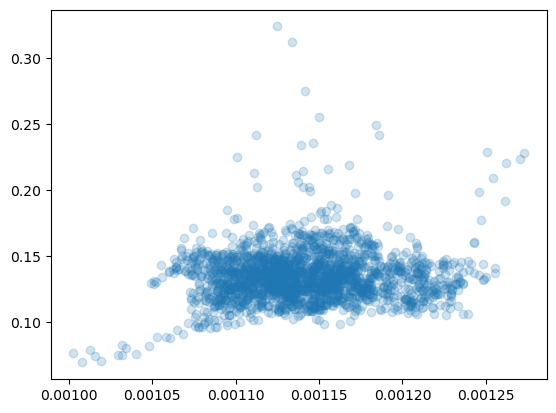

In [17]:
plt.scatter(force_uq_avg, force_error_avg, alpha=0.2)

<Axes: >

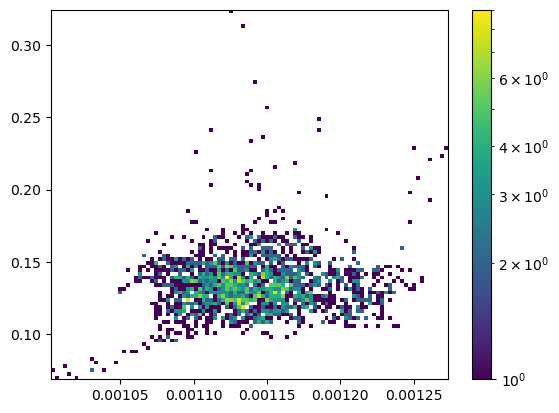

In [22]:
scatter_hist(force_uq_avg, force_error_avg, identity=False, best_fit=False, bins=100)

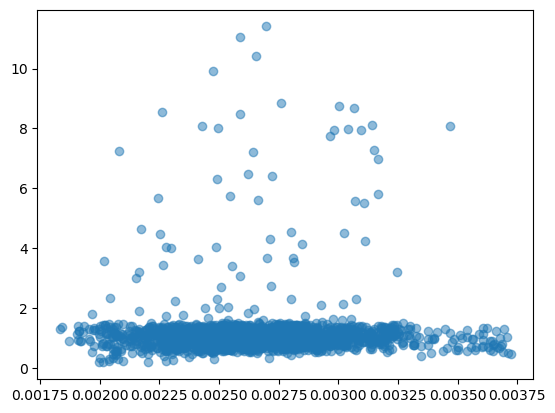

In [25]:
plt.scatter(force_uq_max, force_error_max, alpha=0.5)

<Axes: >

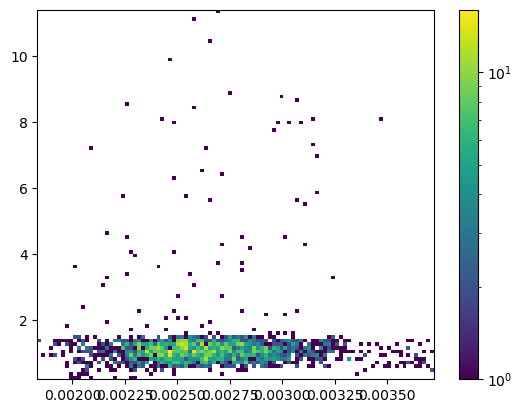

In [23]:
scatter_hist(force_uq_max, force_error_max, identity=False, best_fit=False, bins=100)

In [30]:
import UQtools

In [36]:
from UQtools import order_sig_and_errors, get_slope_metric, spearman_rank_corr, expected_rho, calibration_curve, calibration_area, plot_calibration_curve, plot_Z_scores, NLL

In [39]:
ordered_df = order_sig_and_errors(force_uq_avg, force_error_avg)

In [40]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

miscalibration area = 0.50


R squared: 0.18124886825535225
intercept: 0.0933882600055227
slope: 37.27852125889025


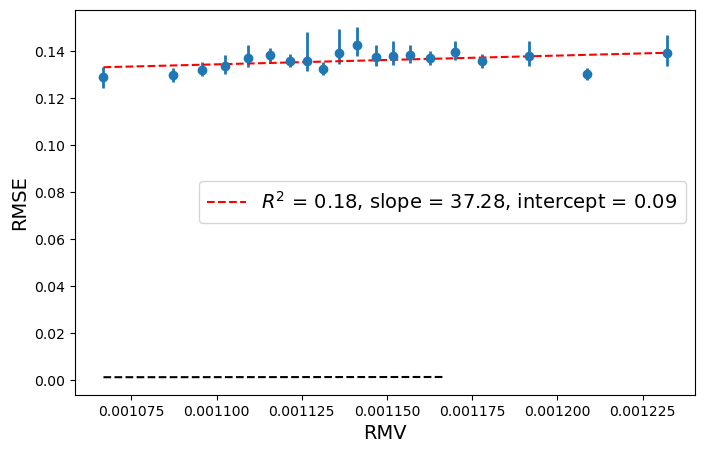

In [41]:
fig, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

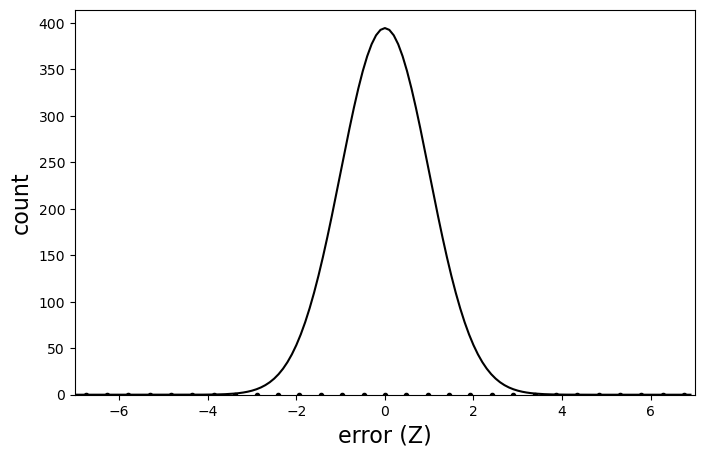

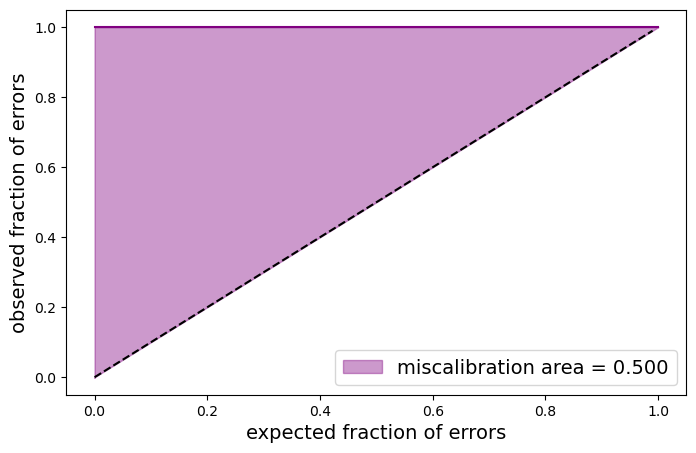

In [42]:
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [47]:
ordered_df['error'] = ordered_df['errors']

In [48]:
from scipy.stats import bootstrap
df = ordered_df
Z = (df.error)/df.uq
Z_var = np.var(Z)
interval_var = bootstrap((Z,), np.var)
print(f'var(Z) = {Z_var:.2f} CI = {interval_var.confidence_interval}')
Z_mean = np.mean(Z)
interval_mean = bootstrap((Z,), np.mean)
print(f'mean(Z) = {Z_mean:.2f} CI = {interval_mean.confidence_interval}')

var(Z) = 302.90 CI = ConfidenceInterval(low=265.1299726910946, high=369.11843490670395)
mean(Z) = 117.98 CI = ConfidenceInterval(low=117.28567840116747, high=118.78538388372661)


## That seems pretty bad. What happens if we dont do any aggregation over atoms and spatial dimensions -- how is it in this case? 

In [57]:
# each array is (n_trajectories, n_timesteps)
force_error_avg, force_error_max = np.zeros((4, 512)), np.zeros((4,512))
force_uq_avg, force_uq_max = np.zeros((4, 512)), np.zeros((4,512))

force_errors = np.zeros((4,512,101,3))
force_uqs    = np.zeros((4,512,101,3))
for seed in range(4):
    traj = trajectories_ft[seed]
    for timestep in range(len(traj)): 
        atoms = traj[timestep]
        forces = atoms.get_forces()
        ref_forces = forces_dft[seed][timestep]
        # look at the absolute force error
        force_errors[seed,timestep,:] = np.abs(forces - ref_forces)
        # and the stdev of the predicted forces along the ensemble direction
        force_uqs[seed,timestep,:] = np.sqrt(forces_comm[seed][timestep].var(0))
force_error, force_uq = map(lambda a: a.ravel(), [force_errors, force_uqs])

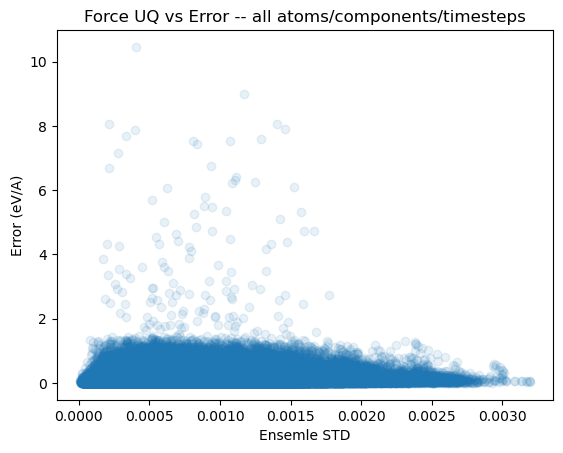

In [75]:
plt.scatter(force_uq, force_error, alpha=0.1)
plt.xlabel('Ensemle STD')
plt.ylabel(r'Error (eV/A)');
plt.title('Force UQ vs Error -- all atoms/components/timesteps');

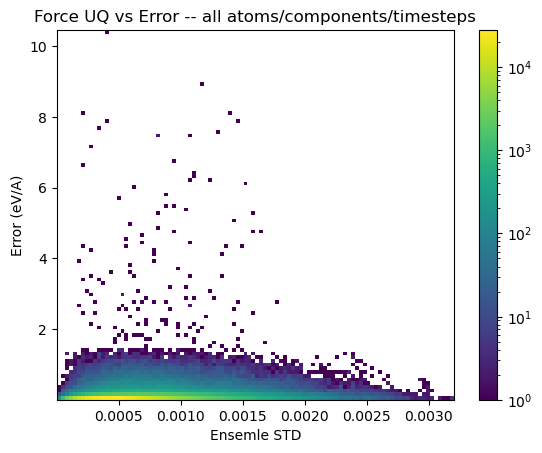

In [76]:
scatter_hist(force_uq, force_error, identity=False, best_fit=False, bins=100)
plt.xlabel('Ensemle STD')
plt.ylabel(r'Error (eV/A)');
plt.title('Force UQ vs Error -- all atoms/components/timesteps');

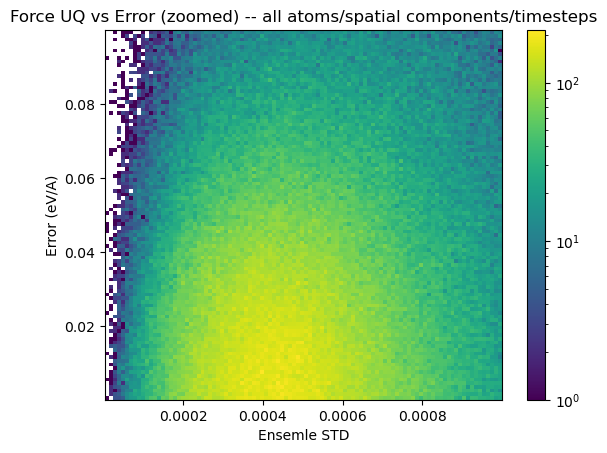

In [84]:
keep_ix = (force_error <= 0.1) & (force_uq <= 0.001)

scatter_hist(force_uq[keep_ix], force_error[keep_ix], identity=False, best_fit=False, bins=100)
plt.xlabel('Ensemle STD')
plt.ylabel(r'Error (eV/A)');
plt.title('Force UQ vs Error (zoomed) -- all atoms/spatial components/timesteps');

Thats pretty bad...

In [85]:
ordered_df = order_sig_and_errors(force_uq, force_error)

In [86]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

miscalibration area = 0.49


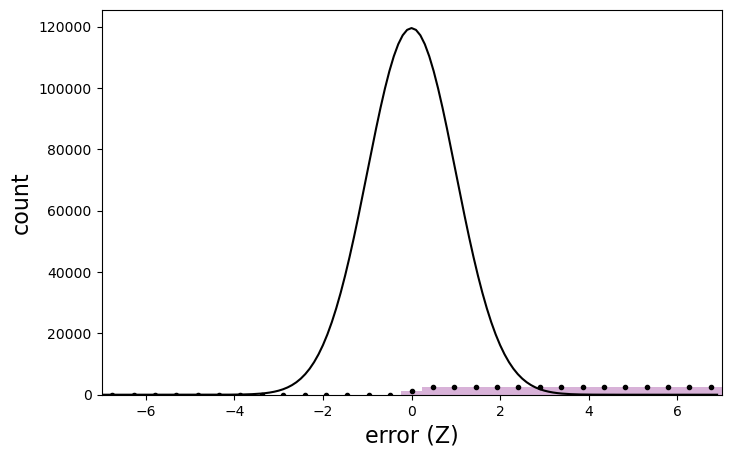

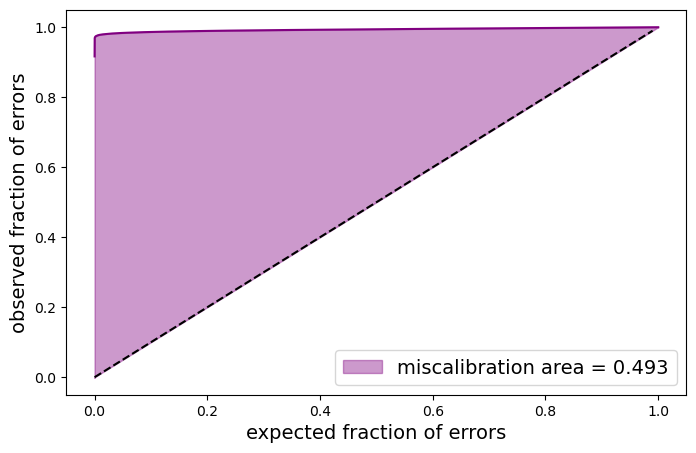

In [87]:
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)